In [17]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
from ortools.constraint_solver import pywrapcp,routing_enums_pb2
import osmnx as ox
import networkx as nx
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [18]:
df = pd.read_csv('data_stores.csv')


In [19]:
state = "NC"
country = "US"
city = ""
df_state = df[(df['State/Province'] == state) & (df['Country'] == 'US') & ()][["City", "Street Address", "Latitude", "Longitude"]].sample(frac=1).reset_index(drop=True)
df_state = df_state.reset_index().rename(columns={"index":"id","Latitude":"y","Longitude":"x"})

In [20]:
df_state.head()

id        City                           Street Address      y      x
0   0  Washington  1301 Connecticut Avenue NW, The Portals  38.91 -77.04
1   1  Washington                 1331 Pennsylvania Ave NW  38.90 -77.03
2   2  Washington               4820 Massachusetts Ave. NW  38.94 -77.10
3   3  Washington                    3336 Wisconsin Ave NW  38.93 -77.07
4   4  Washington                 500 New Jersey Avenue NW  38.90 -77.01

In [21]:
df_state.shape

(91, 5)

In [22]:
data = df_state.copy()
data = data.drop_duplicates((['x','y']),keep='first')

In [23]:
data["Color"] = ''
data.loc[data['id']==0,'Color'] = 'red'
data.loc[data['id']!=0, 'Color'] = 'black'

start = data[data['id']==0][['y','x']].values[0]

In [24]:
data.shape

(47, 6)

In [25]:
data.head(3)
#print('starting point coordinations', start)

id        City                           Street Address      y      x  \
0   0  Washington  1301 Connecticut Avenue NW, The Portals  38.91 -77.04   
1   1  Washington                 1331 Pennsylvania Ave NW  38.90 -77.03   
2   2  Washington               4820 Massachusetts Ave. NW  38.94 -77.10   

   Color  
0    red  
1  black  
2  black

In [26]:
map = folium.Map(location= start, titles = 'carthodbpositron', zoom_start=12)
data.apply(lambda row:
           folium.CircleMarker(
               location= [row['y'],row['x']],
               color = row['Color'],fill = True,radius=5
           ).add_to(map),axis=1)
map

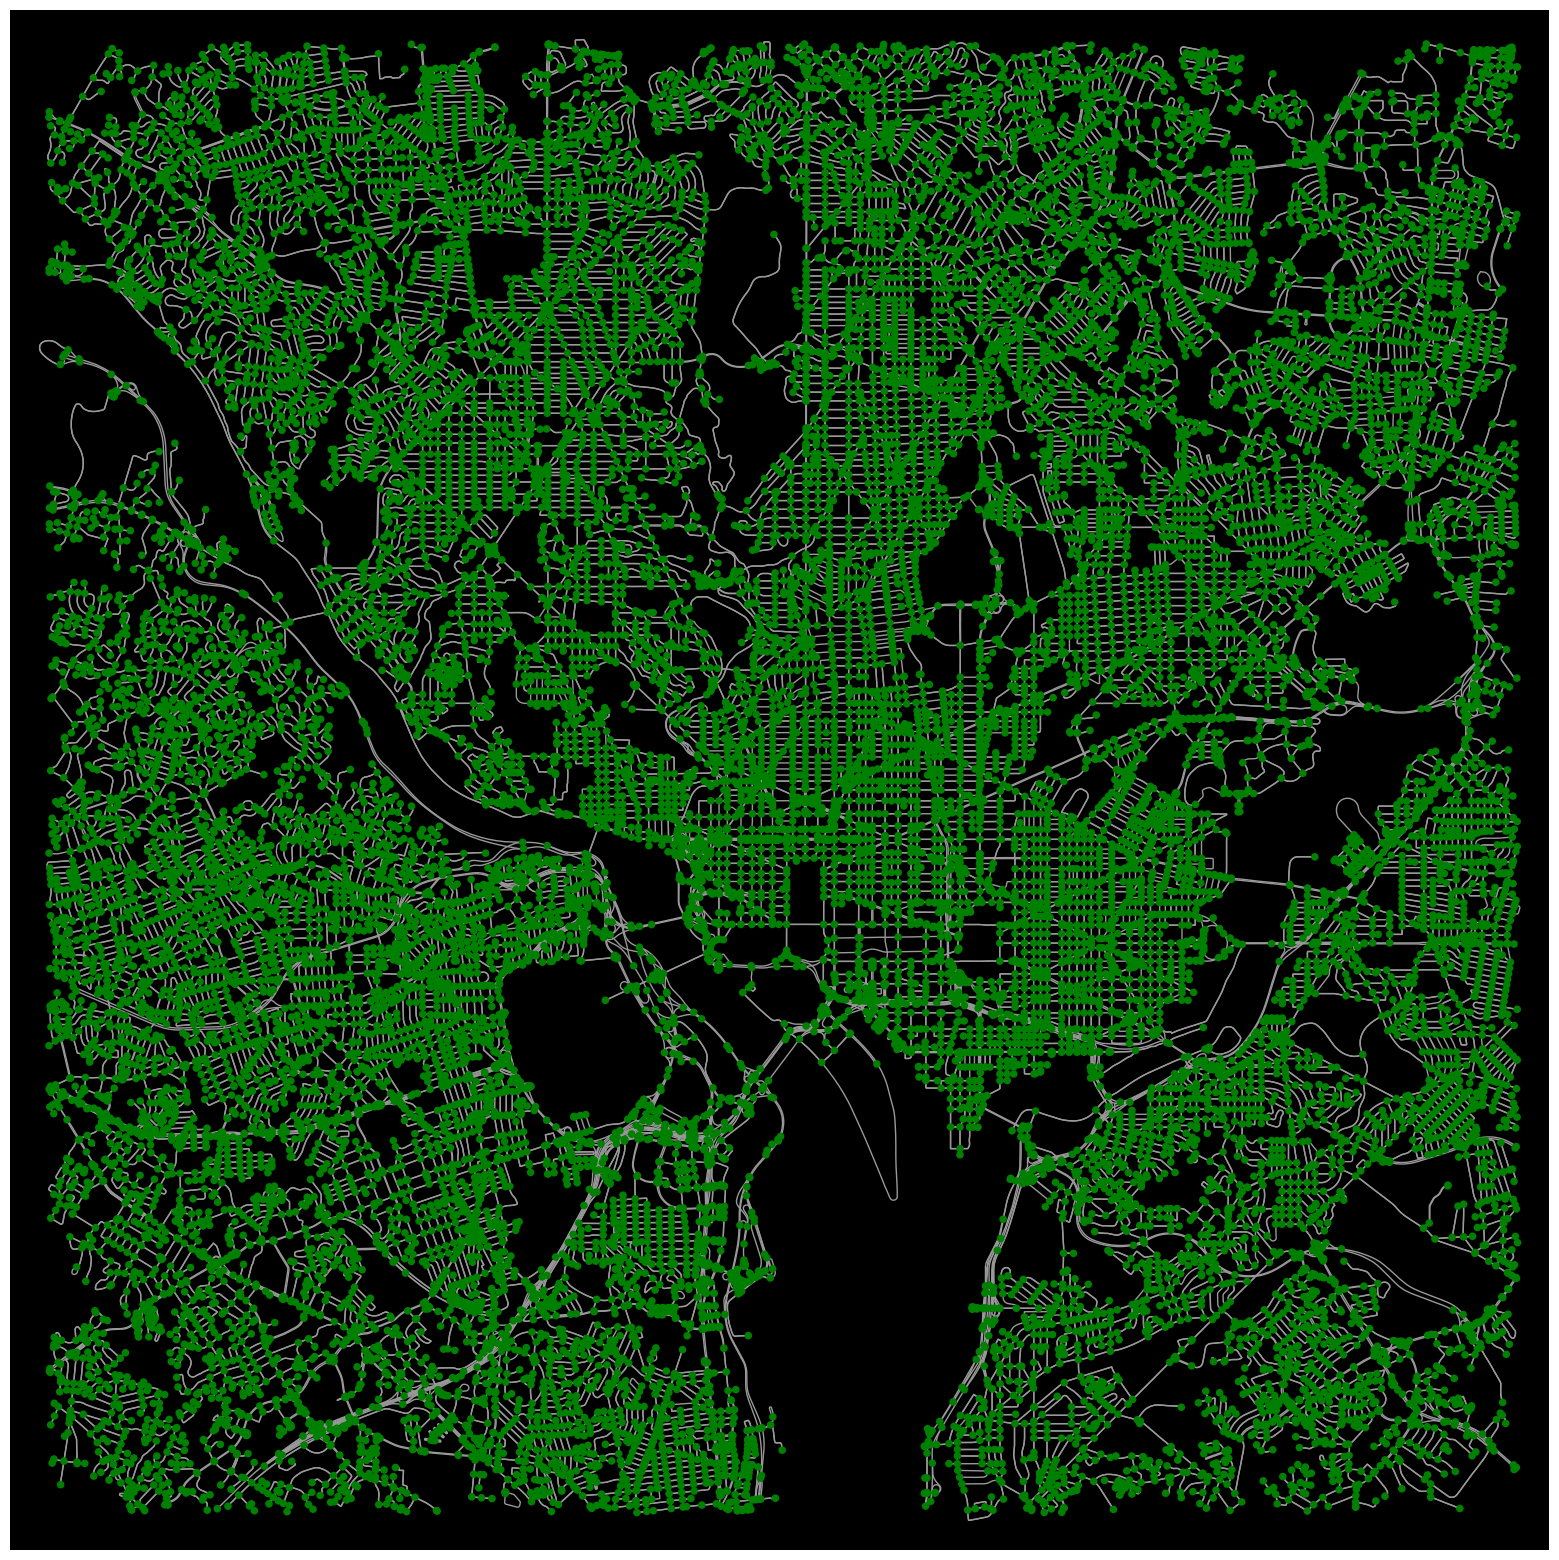

In [27]:
G = ox.graph_from_point(start, dist=10000, network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

fig,ax = ox.plot_graph(G,bgcolor="black", node_size = 30, node_color = 'green', figsize = (30,20))

In [28]:
start_node=ox.distance.nearest_nodes(G, start[1], start[0])
df_state["node"]=df_state[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
df_state=df_state.drop_duplicates("node", keep='first')
df_state.head()

id        City                           Street Address      y      x  \
0   0  Washington  1301 Connecticut Avenue NW, The Portals  38.91 -77.04   
1   1  Washington                 1331 Pennsylvania Ave NW  38.90 -77.03   
2   2  Washington               4820 Massachusetts Ave. NW  38.94 -77.10   
3   3  Washington                    3336 Wisconsin Ave NW  38.93 -77.07   
4   4  Washington                 500 New Jersey Avenue NW  38.90 -77.01   

         node  
0    49770672  
1  3027616118  
2    49829604  
3  2424854392  
4   647026143

In [29]:
df_state.shape

(47, 6)

In [30]:
def f(a , b):
    try:
        d=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d

distance_matrix=np.asarray([[f(a,b)for b in df_state["node"].tolist()] for a in df_state["node"].tolist()])
distance_matrix=pd.DataFrame(distance_matrix, columns=df_state["node"].values, index=df_state["node"].values)

distance_matrix.head()


49770672    3027616118  49829604    2424854392  647026143   \
49770672           0.0       127.0       546.3       353.2       240.6   
3027616118       182.3         0.0       652.0       458.9       150.2   
49829604         547.6       641.5         0.0       254.5       760.1   
2424854392       355.1       449.0       261.2         0.0       567.6   
647026143        278.1       140.9       748.2       555.1         0.0   

            49813499    49770782    1488873885  49760266    49777795    ...  \
49770672         249.1        97.7       318.5       319.9       172.5  ...   
3027616118       291.1        89.4       389.5       423.0        76.3  ...   
49829604         573.9       582.4       311.7       341.7       692.0  ...   
2424854392       377.0       389.9       119.2        87.2       499.5  ...   
647026143        366.7       213.6       507.6       523.1        77.0  ...   

            49813715    49780193    49820699    49822546    650017955   \
49770672         571.7       424.8       340.3       605.7       218.7   
3027616118       639.7       527.9       443.4       673.7        98.8   
49829604         628.1       295.7       320.9       695.2       733.2   
2424854392       581.0       147.2       168.7       648.1       540.7   
647026143        638.3       628.0       543.5       610.0       211.7   

            49826564    49828276    49749265    49742711    2428739670  
49770672         421.1       245.8       668.9       486.1       194.8  
3027616118       330.7       316.8       578.5       521.2       225.2  
49829604         940.6       408.5      1188.4       256.4       518.3  
2424854392       748.1       216.0       995.9       330.1       325.8  
647026143        262.0       434.9       521.7       639.2       343.2  

[5 rows x 47 columns]

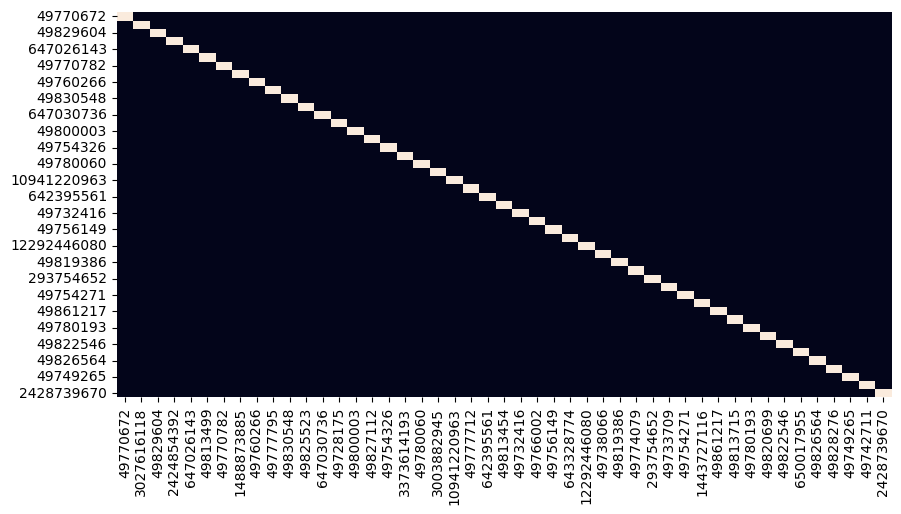

In [31]:
heatmap= distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col]=heatmap[col].apply(lambda x: 
         0.3 if pd.isnull(x) else
         (0.7 if np.isinf(x) else 
          (0 if x!=0 else 1)) )
    
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0 , vmax=1 , cbar=False, ax=ax)
plt.show()



In [32]:
distance_matrix= distance_matrix.round()
distance_matrix=distance_matrix.astype('int')
distance_matrix



49770672    3027616118  49829604    2424854392  647026143   \
49770672              0         127         546         353         241   
3027616118          182           0         652         459         150   
49829604            548         641           0         255         760   
2424854392          355         449         261           0         568   
647026143           278         141         748         555           0   
49813499            224         291         561         366         362   
49770782            129          66         588         395         216   
1488873885          312         374         312         119         517   
49760266            319         419         348          87         542   
49777795            221          74         691         498          84   
49830548            400         223         864         671         227   
49825523            355         413         684         489         401   
647030736           269         169         763         570          76   
49728175            101         181         462         269         301   
49800003            543         574         134         250         717   
49827112            113         240         523         300         354   
49754326            576         676         285         296         799   
3373614193          461         554          88         168         673   
49780060            192         133         687         493         145   
3003882945          292         117         760         567         160   
10941220963         179         256         452         259         388   
49777712            162         152         553         360         301   
642395561           419         258         889         696         205   
49813454            147         197         628         418         283   
49732416            406         386         752         558         293   
49766002            473         336         943         750         195   
49756149            456         541         159         183         669   
643328774           569         406         865         674         489   
12292446080         499         593         216         173         712   
49738066            836         675        1307        1113         622   
49819386            406         268         876         683         146   
49774079            339         202         809         616          61   
293754652           462         298         864         672         382   
49733709            339         162         804         611         225   
49754271            533         633         319         276         756   
1443727116          222         225         711         504         237   
49861217            113          96         606         413         202   
49813715            547         642         621         578         637   
49780193            422         522         293         147         645   
49820699            339         440         318         169         562   
49822546            581         676         693         650         609   
650017955           296         132         760         567         283   
49826564            476         314         946         753         261   
49828276            248         295         409         216         438   
49749265            733         572        1203        1010         518   
49742711            493         492         257         333         636   
2428739670          222         219         524         331         362   

             49813499    49770782    1488873885  49760266    49777795    ...  \
49770672            249          98         318         320         172  ...   
3027616118          291          89         390         423          76  ...   
49829604            574         582         312         342         692  ...   
2424854392          377         390         119          87         500  ...   
647026143   

In [34]:


drivers = 1 
lst_nodes= df_state["node"].tolist()
print("start:", start_node, "total locations to visit", len(lst_nodes)-1, "drivers", drivers)



start: 49770672 total locations to visit 46 drivers 1


In [35]:


manager= pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model=pywrapcp.RoutingModel(manager)



In [36]:


def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance=model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy= (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)



In [37]:
solution= model.SolveWithParameters(parameters)

index=model.Start(0)
print('route for driver:')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index=index
    index=solution.Value(model.NextVar(index))
    
    try:
        route_distance +=get_distance(previous_index, index)
    except:
        route_distance+=model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)
        
print(route_idx)
print(f'Total distance:{round(route_distance/1000,2)}km')
print(f'Nodes visited: {len(route_idx)}')


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7002abe29f10>>
Traceback (most recent call last):
  File "/home/amir_k/Documents/Programming/Python/route_optimization/route_optimization/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "/home/amir_k/anaconda3/lib/python3.12/threading.py", line 1541, in enumerate
    with _active_limbo_lock:
SystemError: <built-in method __enter__ of _thread.RLock object at 0x7002ae51d4c0> returned a result with an exception set
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7002abe29f10>>
Traceback (most recent call last):
  File "/home/amir_k/Documents/Programming/Python/route_optimization/route_optimizat

route for driver:
[0, 13, 20, 43, 7, 3, 8, 38, 39, 28, 16, 34, 17, 2, 14, 26, 45, 46, 21, 6, 1, 32, 27, 33, 29, 44, 25, 37, 40, 24, 11, 15, 5, 23, 35, 12, 18, 36, 41, 19, 10, 22, 42, 30, 31, 4, 9]
Total distance:8.84km
Nodes visited: 47


In [38]:


print("Route for driver (nodes):")
lst_route=[lst_nodes[i] for i in route_idx]
print(lst_route)



Route for driver (nodes):
[49770672, 49728175, 10941220963, 49828276, 1488873885, 2424854392, 49760266, 49780193, 49820699, 12292446080, 49754326, 49754271, 3373614193, 49829604, 49800003, 49756149, 49742711, 2428739670, 49777712, 49770782, 3027616118, 293754652, 643328774, 49733709, 49738066, 49749265, 49766002, 49813715, 49822546, 49732416, 49825523, 49827112, 49813499, 49813454, 1443727116, 647030736, 49780060, 49861217, 650017955, 3003882945, 49830548, 642395561, 49826564, 49819386, 49774079, 647026143, 49777795]


In [39]:


def get_path_between_nodes(lst_route):
    lst_paths=[]
    for i in range (len(lst_route)):
        try :
            a , b = lst_nodes[i], lst_nodes[i+1]
        except:
            break
        try:
            path=nx.shortest_path(G, source=a, target=b, method ='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths= get_path_between_nodes(lst_route)

for path in lst_paths:
    ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)
    
map



In [40]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    df=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], [] 
        
        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])
            
        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)), 
                         columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        df=pd.concat([df,tmp], ignore_index=(not parallel))
        
    df=df.reset_index().rename(columns={"index":"id"})
    return df
            

In [41]:
df= pd.DataFrame()
tmp=df_animation_multiple_path(G, lst_paths, parallel=False)
df=pd.concat([df, tmp], axis=0)
first_node, last_node= lst_paths[0][0], lst_paths[-1][-1]


In [42]:
df_start= df[df["start"]== first_node]
df_end=df[df["end"]== last_node]

fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y", zoom=15, width=900, height=700, animation_frame="id",mapbox_style="carto-positron")

fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=df_state, lon="x", lat="y").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"green"}

fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])

fig